# Tutorial 4: Analysis and Post-processing

**Overview:** This notebook covers the basics of data analysis and post-processing using Dedalus. Analysis tasks can be specified symbolically and are saved to distributed HDF5 files.

In [1]:
import pathlib
import subprocess
import h5py
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3

2021-12-02 22:30:27,705 numexpr.utils 0/1 INFO :: Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-12-02 22:30:27,706 numexpr.utils 0/1 INFO :: NumExpr defaulting to 8 threads.


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# Clean up any old files
import shutil
shutil.rmtree('analysis', ignore_errors=True)

## 4.1: Analysis

Dedalus includes a framework for evaluating and saving arbitrary analysis tasks while an initial value problem is running.
To get started, let's setup the complex Ginzburg-Landau problem from the previous tutorial.

In [4]:
# Basis
xcoord = d3.Coordinate('x')
dist = d3.Distributor(xcoord, dtype=np.complex128)
xbasis = d3.Chebyshev(xcoord, 1024, bounds=(0, 300), dealias=2)

# Fields
u = dist.Field(name='u', bases=xbasis)
tau1 = dist.Field(name='tau1')
tau2 = dist.Field(name='tau2')

# Substitutions
dx = lambda A: d3.Differentiate(A, xcoord)
magsq_u = u * np.conj(u)
b = 0.5
c = -1.76

# Tau polynomials
tau_basis = xbasis.clone_with(a=1.5, b=1.5)
p1 = dist.Field(bases=tau_basis)
p2 = dist.Field(bases=tau_basis)
p1['c'][-1] = 1
p2['c'][-2] = 2

# Problem
problem = d3.IVP([u, tau1, tau2], namespace=locals())
problem.add_equation("dt(u) - u - (1 + 1j*b)*dx(dx(u)) + tau1*p1 + tau2*p2 = - (1 + 1j*c) * magsq_u * u")
problem.add_equation("u(x='left') = 0")
problem.add_equation("u(x='right') = 0")

# Solver
solver = problem.build_solver(d3.RK222)
solver.stop_sim_time = 500

# Initial conditions
x = dist.local_grid(xbasis)
u['g'] = 1e-3 * np.sin(5 * np.pi * x / 300)

2021-12-02 22:30:27,853 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+01/s


### Analysis handlers

The explicit evaluation of analysis tasks during timestepping is controlled by the `solver.evaluator` object.
Various handler objects can be attached to the evaluator, and control when the evaluator computes their own set of tasks and what happens to the resulting data.

For example, an internal `SystemHandler` object directs the evaluator to evaluate the RHS expressions on every iteration, and uses the data for the explicit part of the timestepping algorithm.

For simulation analysis, the most useful handler is the `FileHandler`, which regularly computes tasks and writes the data to HDF5 files.
When setting up a file handler, you specify the name/path for the output directory/files, as well as the cadence at which you want the handler's tasks to be evaluated.
This cadence can be in terms of any combination of 

* simulation time, specified with `sim_dt`
* wall time, specified with `wall_dt`
* iteration number, specified with `iter`

To limit file sizes, the output from a file handler is split up into different "sets" over time, each containing some number of writes that can be limited with the `max_writes` keyword when the file handler is constructed.

Let's setup a file handler to be evaluated every few iterations.

In [5]:
analysis = solver.evaluator.add_file_handler('analysis', iter=10, max_writes=400)

You can add an arbitrary number of file handlers to save different sets of tasks at different cadences and to different files.

### Analysis tasks

Analysis tasks are added to a given handler using the `add_task` method.
Tasks are entered as operator expressions or in plain text and parsed using the same namespace that is used for equation entry.
For each task, you can additionally specify the output layout, scaling factors, and a referece name.

Let's add tasks for tracking the average magnitude of the solution.

In [6]:
analysis.add_task(d3.Integrate(np.sqrt(magsq_u),'x')/300, layout='g', name='<|u|>')

For checkpointing, you can also simply specify that all of the state variables should be saved using the `add_tasks` method.

In [7]:
analysis.add_tasks(solver.state, layout='g')

We can now run the simulation just as in the previous tutorial, but without needing to manually save any data during the main loop.
The evaluator will automatically compute and save the specified analysis tasks at the proper cadence as the simulation is advanced.

In [8]:
# Main loop
timestep = 0.05
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 1000 == 0:
        print('Completed iteration {}'.format(solver.iteration))

Completed iteration 1000
Completed iteration 2000
Completed iteration 3000
Completed iteration 4000
Completed iteration 5000
Completed iteration 6000
Completed iteration 7000
Completed iteration 8000
Completed iteration 9000
Completed iteration 10000
2021-12-02 22:30:36,900 solvers 0/1 INFO :: Simulation stop time reached.


## 4.2: Post-processing

### File arrangement

By default, the output files for each file handler are arranged as follows:
1. A base folder taking the name that was specified when the file handler was constructed, e.g. `analysis/`.
2. Within the base folder are subfolders for each set of outputs, with the same name plus a set number, e.g. `analysis_s0/`.
3. Within each set subfolder are HDF5 files for each process, with the same name plus a process number, e.g. `analysis_s0_p1.h5`.
4. An HDF5 virtual file combining the process files for each set.

Let's take a look at the output files from our example problem.
We should see five sets (10000 total iterations, output every 10 iterations, 200 writes per file) and data from one process (indexed starting from 0).

In [9]:
print(subprocess.check_output("find analysis | sort", shell=True).decode())

analysis
analysis/analysis_s1
analysis/analysis_s1.h5
analysis/analysis_s1/analysis_s1_p0.h5
analysis/analysis_s2
analysis/analysis_s2.h5
analysis/analysis_s2/analysis_s2_p0.h5
analysis/analysis_s3
analysis/analysis_s3/analysis_s3_p0.h5



### Handling data

Each HDF5 file contains a "tasks" group containing a dataset for each task assigned to the file handler.
The first dimension of the dataset is time,  and the subsequent dimensions are the spatial dimensions of the output field.

The HDF5 datasets are self-describing, with dimensional scales attached to each axis.
For the first axis, these include the simulation time, wall time, iteration, and write number.
For the spatial axes, the scales correspond to grid points or modes, based on the task layout.
See the [h5py docs](http://docs.h5py.org/en/latest/) for more details.

Let's open up the virtually merged analysis file and plot time series of the average magnitude.

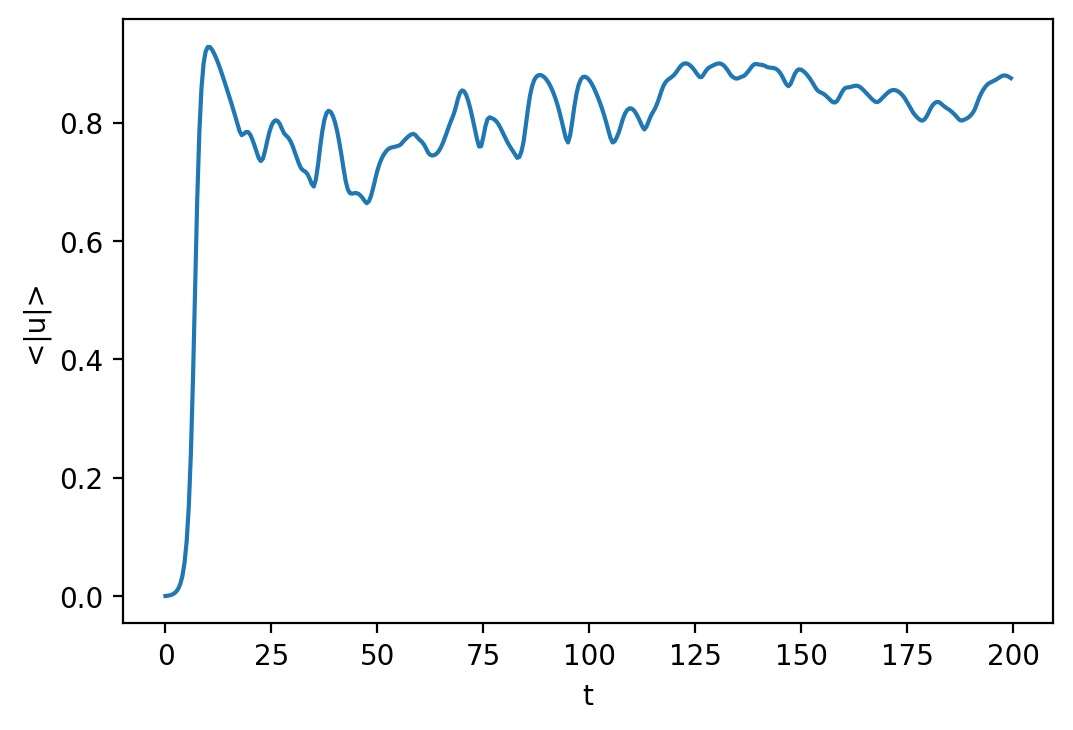

In [10]:
with h5py.File("analysis/analysis_s1.h5", mode='r') as file:
    # Load datasets
    mag_u = file['tasks']['<|u|>']
    t = mag_u.dims[0]['sim_time']
    # Plot data
    fig = plt.figure(figsize=(6, 4), dpi=100)  
    plt.plot(t[:], mag_u[:].real)
    plt.xlabel('t')
    plt.ylabel('<|u|>')

Now let's look at the saved solution over space and time.
Let's plot the phase this time instead of the amplitude.

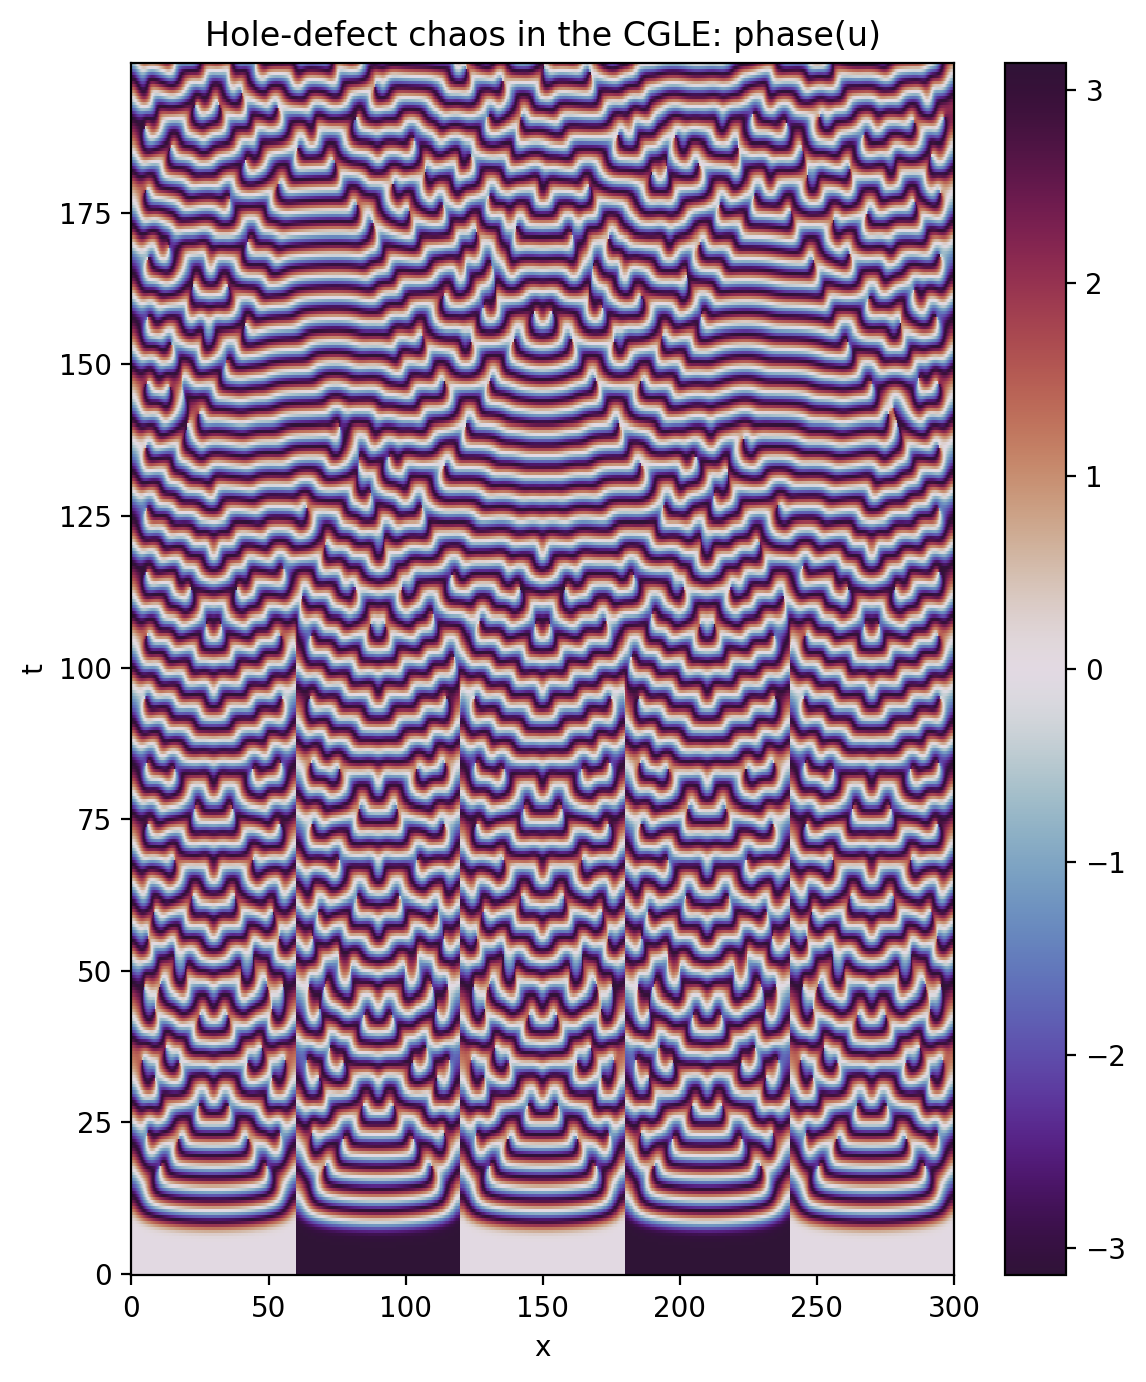

In [11]:
with h5py.File("analysis/analysis_s1.h5", mode='r') as file:
    # Load datasets
    u = file['tasks']['u']
    t = u.dims[0]['sim_time']
    x = u.dims[1][0]
    # Plot data
    u_phase = np.arctan2(u[:].imag, u[:].real)
    plt.figure(figsize=(6,7), dpi=100)
    plt.pcolormesh(x[:], t[:], u_phase, shading='nearest', cmap='twilight_shifted')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('Hole-defect chaos in the CGLE: phase(u)')
    plt.tight_layout()